### ASTR-324, University of Washington


# Week 3.2: Robust Statistics, Histograms, Distributions

## Robust Statistics

In [1]:
%matplotlib inline
import numpy as np
from astroML import stats as astroMLstats

In [43]:
import numpy as np
from scipy.stats import cauchy
from matplotlib import pyplot as plt

def plot_cauchy():
    #----------------------------------------------------------------------
    # This function adjusts matplotlib settings for a uniform feel in the textbook.
    # Note that with usetex=True, fonts are rendered with LaTeX.  This may
    # result in an error if LaTeX is not installed on your system.  In that case,
    # you can set usetex to False.

    #------------------------------------------------------------
    # Define the distribution parameters to be plotted
    gamma_values = [0.5, 1.0, 2.0]
    linestyles = ['-', '--', ':']
    mu = 0
    x = np.linspace(-10, 10, 1000)

    #------------------------------------------------------------
    # plot the distributions
    fig, ax = plt.subplots(figsize=(10, 7))

    for gamma, ls in zip(gamma_values, linestyles):
        dist = cauchy(mu, gamma)

        plt.plot(x, dist.pdf(x), ls=ls, color='black',
                 label=r'$\mu=%i,\ \gamma=%.1f$' % (mu, gamma))

    plt.xlim(-4.5, 4.5)
    plt.ylim(0, 0.65)

    plt.xlabel('$x$')
    plt.ylabel(r'$p(x|\mu,\gamma)$')
    plt.title('Cauchy Distribution')

    plt.legend()
    plt.show()

### Cauchy distribution (Lorentzian)

Let's introduce the Cauchy distribution (which may be better known to us as the Lorentzian):

$$f(x \mid x_0,\gamma) = \frac{1}{\pi\gamma \left[1 + \left(\frac{x - x_0}{\gamma}\right)^2\right]} = { 1 \over \pi \gamma } \left[ { \gamma^2 \over (x - x_0)^2 + \gamma^2  } \right]$$

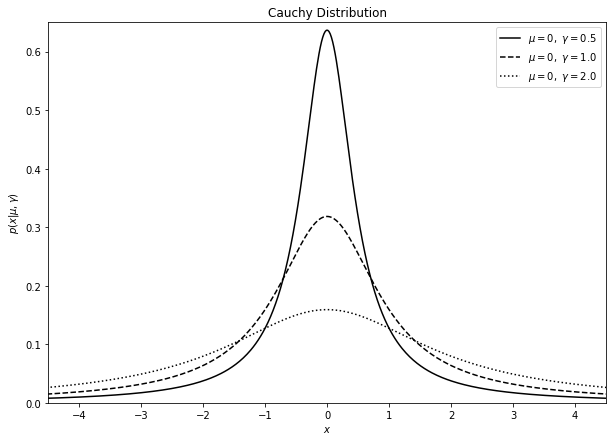

In [10]:
plot_cauchy()

Task: given $N$ measurements ${x_i}$ drawn from a Cauchy distribution, estimate its location parameter $\mu$.

Looking its graph above, it looks like that the sample mean should be a good estimator of $\mu$ (like for the normal distribution). Also, the Central Limit Theorem tells us that the larger the sample N, the better the estimate will be.

Not a problem! Let's draw a sample, compute the mean, and 🎉.

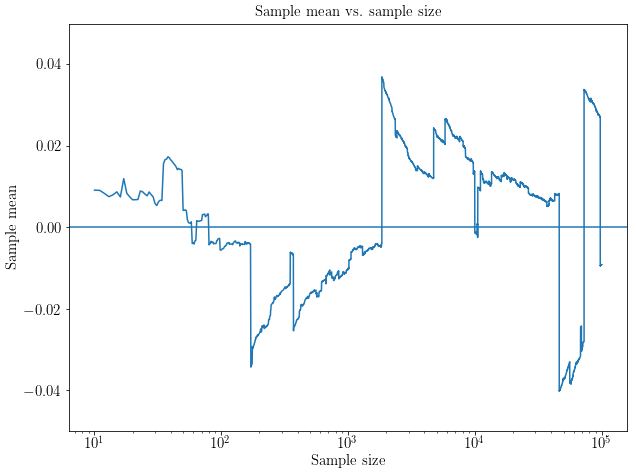

In [90]:
from scipy.stats import norm

np.random.seed(49)
mu = 0
gamma = 0.01
sigma = 0.1
N_max = 100_000

#xi = norm(mu, sigma).rvs(N_max)
xi = cauchy(mu, gamma).rvs(N_max)
N = np.arange(10, N_max)
mean = np.asarray( list( xi[:j].mean() for j in N ) )

fig, ax = plt.subplots(figsize=(10, 7.5))
plt.plot(N, mean)
ax.set_xscale('log')
ax.axhline(0.)
plt.ylim(-0.05, 0.05)

plt.xlabel('Sample size')
plt.ylabel(r'Sample mean')
plt.title('Sample mean vs. sample size');

What just happened?!?!

We forgot the read the fineprint on the CLT! The CLT states that the precision of the estimate will grow as:

$$ \frac{\sigma}{\sqrt N} $$

but if you try to compute $\sigma^2 = E[(x-\mu)^2]$ for the Lorentzian you'll quickly discover that integral is not defined (you'll get something like $\infty - \infty$)!

Intuitively, what happens is that the Lorentzian has "fat tails" -- the probability doesn't drop very rapidly for large values away from its center. It means there's always relatively high chance to draw a large number which will strongly influence the mean. If you then take 10x more samples, because of the fat tails in 10x as many draws you'll still have a high probability to draw a 10x as large outlier as before. No matter how many samples you take, you're always likely to draw an outlier that will sway the entire mean.

What do we do instead?

## Median

Instead, we compute the **median**. The median is the middle value in the sorted sample. For example, given:

$$\{ x_i \} = \{ -40, -7,  6, 38, 42, 44, 5420 \}$$

the median is $38$. Question: what would be the mean of the above sample?

While it is perhaps most common to compute the mean, the ***median*** is a more ***robust estimator*** of the location of the distribution (of the ["central tendency"](https://en.wikipedia.org/wiki/Central_tendency)).  That's because it is less affected by outliers.

In [58]:
# Execute this cell.  Think about what it is doing.
np.random.seed(42)
data0 = norm(0.5, 0.1).rvs(10_000)
mean = np.mean(data0)
median = np.median(data0)
stdev = np.std(data0)

data = data0.copy()
mask = data>0.7
data[mask] = data[mask]*10
newmean = np.mean(data)
newmedian = np.median(data)
newstdev = np.std(data)

print('the number of modified points:', np.sum(mask))
print('mean:', mean, newmean)
print('median:', median, newmedian)
print('st.dev.:', stdev, newstdev)

the number of modified points: 237
mean: 0.49978640166315735 0.6570224015274856
median: 0.4997405024207122 0.4997405024207122
st.dev.: 0.10034122061299877 1.0516756397326106


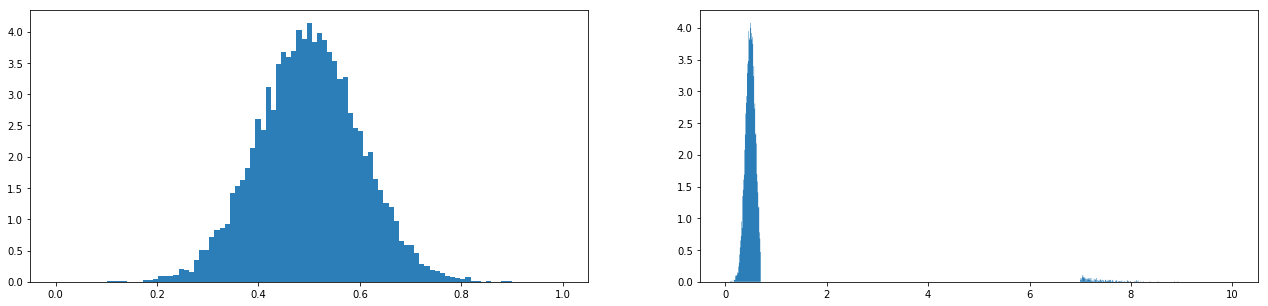

In [64]:
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(22, 5))
ax0.hist(data0, bins=np.linspace(0, 1, 100), histtype='stepfilled', alpha=0.95, normed=True);
ax1.hist(data,  bins=np.linspace(0, 10, 1000), histtype='stepfilled', alpha=0.95, normed=True);

### Generalizing from the median: Percentiles and quartiles

Percentiles, $q_p$, are computed as
$$\frac{p}{100} = \int_{-\infty}^{q_p}h(x) dx$$

For example, the 25th, 50th, and 75th percentiles of samples drawn from a $N(\mu=100, \sigma=15)$ distribution:

In [5]:
# execute:
mu=100
sigma=15
sampleSize=1_000_000
data = norm(mu, sigma).rvs(sampleSize) 

q25 = np.percentile(data, 25)
q50 = np.percentile(data, 50)
q75 = np.percentile(data, 75)

print(q25, q50, q75)

89.8351752639064 99.98304507722892 110.10218701536567


The difference between the 25th and 75th percentiles, $q_{75} - q_{25}$, is called the **interquartile range** (IQR). The median and interquartile range are more **robust estimators** of the location and scale parameters than the mean and the standard deviation.

One can also create a robust standard deviation like estimator, from the interquartile range as:

$$\sigma_G = 0.7413(q_{75} - q_{25}).$$

The chosen normalization of 0.7413 makes it an unbiased estimator of the standard deviation, $\sigma$, _if_ the sample was drawn from a Gaussian (it makes $\sigma_G \to \sigma$ as $N \to \infty$).

## No Free Lunch: Reduced Precision

Median and $\sigma_G$ are good estimators of location and scale parameters also in cases when outlier are present (or suspected -- i.e., real world data. Great!

But there's no such thing as a free lunch: the price we pay for using the median instead of the mean is $\sim$20% larger uncertainty (assuming nearly Gaussian distributions).

But this is often a good price to pay to avoid catastrophic failures!

### Demonstration

We'll demonstrate the difference in precision by drawing samples of 10 numbers from a normal distribution 100,000 times, computing the mean and median of each sample, then histogramming the results.

In [69]:
np.random.seed(42)   # ALWAYS SET THE RANDOM SEED!

k = 10               # number of samples in each draw
M = 100000           # number of draws
mu = 1.0             # mean of the gaussian
sigma = 0.1          # standard deviation of the gaussian

## Performing M draws, and computing the mean for each
means = np.zeros(M)   # for storing the mean values obtained in M draws
medians = np.zeros(M) # for storing the median values
for i in range(M):
    x = norm(mu, sigma).rvs(k) # here we draw k numbers from N(mu=1.0, sigma=0.1)
    means[i] = np.mean(x)
    medians[i] = np.median(x)
    
def plot_median_vs_mean_precision():
    fig, ax = plt.subplots(figsize=(10, 7.5))

    ## now plot the histogram of values in array 'means'
    ax.hist(means, bins=np.linspace(0.8, 1.2, 61), histtype='stepfilled', alpha=0.95, normed=True)
    ax.hist(medians, bins=np.linspace(0.8, 1.2, 61), histtype='stepfilled', alpha=0.50, normed=True, color='red')

    ## Overplot the expected gaussian distribution
    xGrid = np.linspace(0, 2, 1000)
    gauss = norm(mu, sigma/np.sqrt(k)).pdf(xGrid)  # this is a function of x: gauss(x)
    plt.plot(xGrid, gauss, ls='-', c='blue', label='Mean $x$')

    gauss = norm(mu, 1.18*sigma/np.sqrt(k)).pdf(xGrid)  # this is a function of x: gauss(x)
    plt.plot(xGrid, gauss, ls='-', c='red', label='Median $x$')

    plt.xlim(0.8, 1.2)
    yMax = 1.2*np.sqrt(k)/np.sqrt(2*np.pi) / sigma 
    plt.ylim(0, yMax)
    plt.xlabel('$\overline{x}$')
    plt.ylabel(r'$p(\overline{x})$')
    plt.title(f'Distribution of M={M} sample means computed from k={k} sized samples drawn from a Gaussian')
    plt.legend()

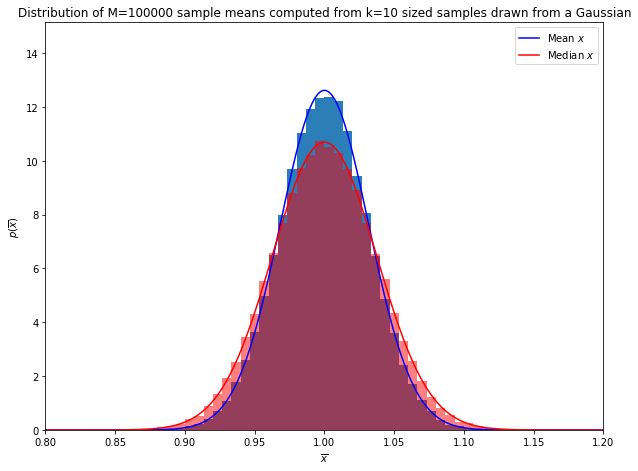

In [70]:
plot_median_vs_mean_precision()

### No Free Lunch: Higher Computational (and Memory) Cost

In [8]:
# execute:
%timeit mean = np.mean(data)
%timeit median = np.median(data)

mean = np.mean(data)
median = np.median(data)

print(f"mean={mean:.3f}, median={median:.3f}")

685 µs ± 113 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
11.3 ms ± 746 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
mean=99.974, median=99.983


In [9]:
# execute
%timeit stdev = np.std(data)
%timeit sigmaG = astroMLstats.sigmaG(data)

stdev = np.std(data)
sigmaG = astroMLstats.sigmaG(data)

print(f"stdev={stdev:.3f}, sigmaG={sigmaG:.3f}")

4.68 ms ± 1.16 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)
18.5 ms ± 443 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
stdev=15.012, sigmaG=15.024


## Beyond a few numbers: Histograms

### What is a histogram?

A histogram a way to represent the distribution of sampled data by sorting the sample into bins (of either constant or variable width). A histogram can also be viewed as an attempt at approximating the underlying sample distribution with a piecewise constant function.

Histograms are a **fantastic tool for early data visualization**. They give us an idea of how the data are distributed and whether notable features exist in their distribution.

#### Some Questions:
* How do we determine/estimate/guess the "proper" bin width?
* Do all bins have to have the same width? (answer: no)
* Are histograms necessary to estimate model parameters? (answer: no!)

### The choice of bin width

![SlideGrab](figures/p29.jpg) 

### The choice of bin placement

Despite the same bin width, a small offset in bin placement can give a very different impression about the behavior of data.

<img src="figures/p30a.png" width=1200>

![SlideGrab](figures/p31.jpg) 

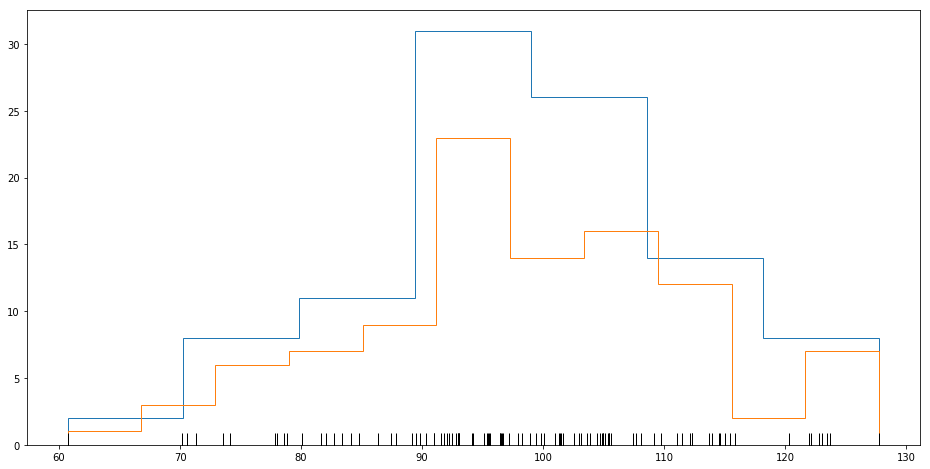

In [82]:
np.random.seed(42)
x = norm(100, 15).rvs(100)
fig, ax = plt.subplots(figsize=(16, 8))
ax.hist(x, bins="scott", histtype="step")
ax.hist(x, bins="fd", histtype="step");
ax.plot(x, 0*x, '|', color='k', markersize=25);

Main take-away points for histograms:
* Fantastic visualization and data exploration tools!
* Some guidelines on how to choose bin width/location, but no magic answers -- try a few hdifferent things, making sure not to draw conclusions sensitive to binning choices. 
* If underlying physics is known, or a functional dependence can be guessed, better to fit models.

We will learn more histogramming tricks later in class -- see:

http://www.astroml.org/book_figures/chapter6/fig_GMM_density_estimation.html

if you can't wait.

## Distributions

Descriptive statistics techniques discussed above can give us a hint as to what the actual underlying distribution may be. Combined with some physical understanding of the process they can lead us to assume the data is being drawn from a specific distribution function -- to ***model*** it.

**If we can justify it, this is assumption is extremely powerful**: it reduces the number of unknowns from dozens or more (e.g., the heights of each bin in a histogram), to one or two parameters that characterize the distribution. These one or two **can then be determined to a significanly greater precision**.

There are many naturally occurring distributions.  The textbook goes through quite a few of them.  Here we'll just talk about a few basic ones to get us started.


### Normal distribution (Gaussian)

$$p(x \mid \mu,\sigma) = \frac{1}{\sigma\sqrt{2\pi}} \exp\left(\frac{-(x-\mu)^2}{2\sigma^2}\right).$$

Notable appearances:
* Diffusion phenomena
* Due to the central limit theorem
* Approximations of various distributions

### Cauchy distribution (Lorentzian)

$$f(x \mid x_0,\gamma) = \frac{1}{\pi\gamma \left[1 + \left(\frac{x - x_0}{\gamma}\right)^2\right]} = { 1 \over \pi \gamma } \left[ { \gamma^2 \over (x - x_0)^2 + \gamma^2  } \right]$$

Notable appearances:
* Spectral line shapes (due to pressure broadening)
* Damped resonant phenomena

In [83]:
def show_lorentz():
    import numpy as np
    from scipy.stats import cauchy
    from matplotlib import pyplot as plt

    #----------------------------------------------------------------------
    # This function adjusts matplotlib settings for a uniform feel in the textbook.
    # Note that with usetex=True, fonts are rendered with LaTeX.  This may
    # result in an error if LaTeX is not installed on your system.  In that case,
    # you can set usetex to False.

    #------------------------------------------------------------
    # Define the distribution parameters to be plotted
    gamma_values = [0.5, 1.0, 2.0]
    linestyles = ['-', '--', ':']
    mu = 0
    x = np.linspace(-10, 10, 1000)

    #------------------------------------------------------------
    # plot the distributions
    fig, ax = plt.subplots(figsize=(10, 7))

    for gamma, ls in zip(gamma_values, linestyles):
        dist = cauchy(mu, gamma)

        plt.plot(x, dist.pdf(x), ls=ls, color='black',
                 label=r'$\mu=%i,\ \gamma=%.1f$' % (mu, gamma))

    plt.xlim(-4.5, 4.5)
    plt.ylim(0, 0.65)

    plt.xlabel('$x$')
    plt.ylabel(r'$p(x|\mu,\gamma)$')
    plt.title('Cauchy Distribution')

    plt.legend()

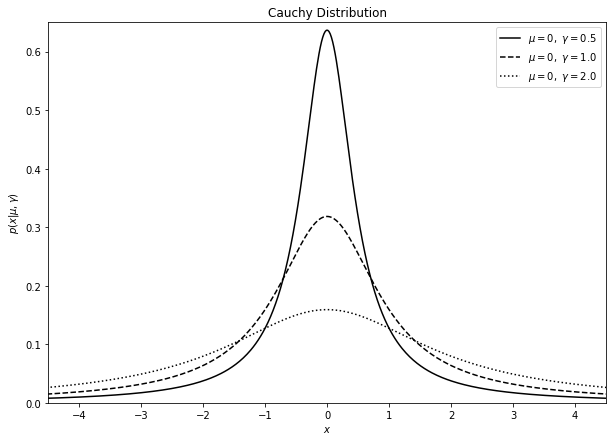

In [84]:
show_lorentz()

### Uniform Distribution

The uniform distribution is perhaps more commonly called a "top-hat" or a "box" distribution.  It is specified by a mean, $\mu$, and a width, $W$, where

$$p(x|\mu,W) = \frac{1}{W}$$

over the range $|x-\mu|\le \frac{W}{2}$ and $0$ otherwise.  That says that "given $\mu$ AND $W$, the probability of $x$ is $\frac{1}{W}$" (as long as we are within a certain range).

We can also compute its standard deviation (square root of the variance, as defined previously), and we find that:

$$\sigma = \frac{W}{\sqrt{12}}.$$


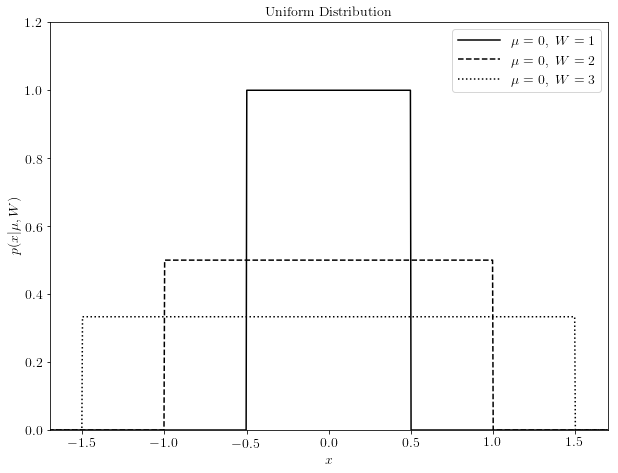

In [12]:
# Execute this cell
%matplotlib inline
%run code/fig_uniform_distribution.py

### Poisson Distribution

"... expresses the probability of a given number of events occurring in a fixed interval of time or space if these events occur with a known constant rate and independently of the time since the last event." (Haight 1967)

$$ P(k \mid \lambda) = e^{-\lambda}\frac{\lambda^k}{k!} $$

where $k$ is the number of events and $\lambda$ is the mean number of events.

#### Notable properties:

For $\lambda > 1000$, Poisson becomes excellently approximated by the normal distribution:

$$ P(k \mid \lambda) \approx N(k \mid \mu=\lambda, \sigma^2=\lambda) $$

(to better than $1\%$ for any value in the $\lambda \pm \sigma$ interval).

#### Notable appearances:
* The number of data points in a bin of a histogram
* The (integer) number of photons collected by the telescope from a star with known average flux.
* The number of decays in a radioactive sample, per time interval.
* And many, many, more...

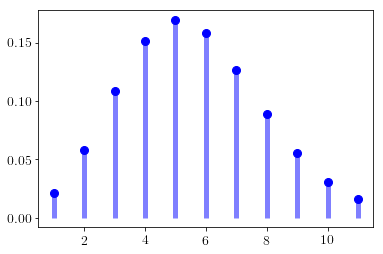

In [13]:
from scipy.stats import poisson
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 1)

mu = 5.6
x = np.arange(poisson.ppf(0.01, mu), poisson.ppf(0.99, mu))
ax.plot(x, poisson.pmf(x, mu), 'bo', ms=8, label='poisson pmf')
ax.vlines(x, 0, poisson.pmf(x, mu), colors='b', lw=5, alpha=0.5)

### Log Normal

Note that if $x$ is Gaussian distributed with $\mathscr{N}(\mu,\sigma)$, then $y=\exp(x)$ will have a **log-normal** distribution, where the mean of y is $\exp(\mu + \sigma^2/2)$.  Try it.

### $\chi^2$ Distribution

If we draw values ${x_i}$ from a Gaussian distribution and we scale and normalize them according to:

$$z_i = \frac{x_i-\mu}{\sigma},$$

then it can be shown that the sum of squares of $z_i$:

$$Q = \sum_{i=1}^N z_i^2,$$

will follow the *$\chi^2$ distribution with $k$ degrees of freedom*.

We'll run into the $\chi^2$ distribution when we talk about Maximum Likelihood; I mention it here largely for completeness.

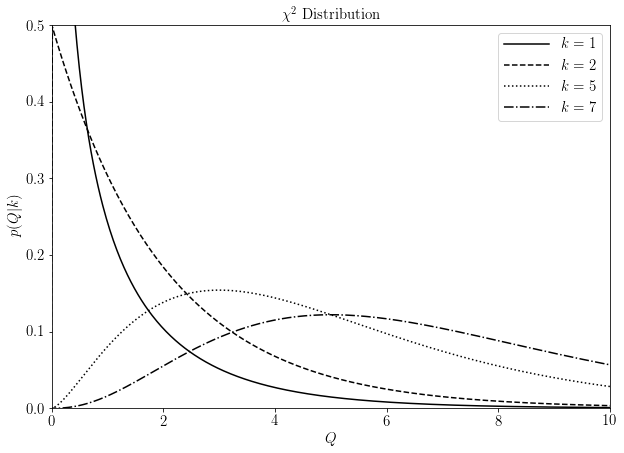

In [85]:
# Execute this cell
%run code/fig_chi2_distribution.py

## Bivariate and Multivariate Distribution Functions

Up to now we have been dealing with one-dimensional distribution functions.  Let's now consider a two dimensional (aka bivariate) distribution 

$$h(x,y)$$

where

$$\int_{-\infty}^{\infty}dx\int_{-\infty}^{\infty}h(x,y)dy = 1.$$

$h(x,y)$ tells us the **joint probability** that $x$ is between $x$ and $x+dx$ and *also* that $y$ is between $y$ and $y+dy$.

If $x$ and $y$ are independent (uncorrelated), then the joint probability will be simply a product of two independent 1-D distributions:

$$h(x,y) = h_x(x) h_y(y)$$

and is usually (much) easier to work with. 

## Bivariate Gaussian

We can write a 2-D Gaussian pdf as
$$p(x,y|\mu_x,\mu_y,\sigma_x,\sigma_y,\sigma_{xy}) = \frac{1}{2\pi \sigma_x \sigma_y \sqrt{1-\rho^2}} \exp\left(\frac{-z^2}{2(1-\rho^2)}\right),$$

where $$z^2 = \frac{(x-\mu_x)^2}{\sigma_x^2} + \frac{(y-\mu_y)^2}{\sigma_y^2} - 2\rho\frac{(x-\mu_x)(y-\mu_y)}{\sigma_x\sigma_y},$$

with $$\rho = \frac{\sigma_{xy}}{\sigma_x\sigma_y}$$
as the (dimensionless) correlation coefficient.

If $x$ and $y$ are perfectly correlated then $\rho=\pm1$ and if they are uncorrelated, then $\rho=0$.

The pdf is now visualized as a 2D histogram (an image!) in the $x-y$ plane. The contours of equal probability are centered at $(x=\mu_x, y=\mu_y)$ and are tilted at angle $\alpha$. This angle is given by

$$\tan(2 \alpha) = 2\rho\frac{\sigma_x\sigma_y}{\sigma_x^2-\sigma_y^2} = 2\frac{\sigma_{xy}}{\sigma_x^2-\sigma_y^2}.$$

For example (Figure 3.22 from the textbook):
![Figure 3.22](http://www.astroml.org/_images/fig_bivariate_gaussian_1.png)

## Moments

We can generalize the moments to multiple dimensions.

For two dimensions:

$$\mu_x = \int_{-\infty}^{\infty}\int_{-\infty}^{\infty}x h(x,y) dx dy$$

$$\mu_y = \int_{-\infty}^{\infty}\int_{-\infty}^{\infty}y h(x,y) dx dy$$

$$\sigma^2_x = \int_{-\infty}^{\infty}\int_{-\infty}^{\infty}(x-\mu_x)^2 h(x,y) dx dy$$

$$\sigma^2_y = \int_{-\infty}^{\infty}\int_{-\infty}^{\infty}(y-\mu_y)^2 h(x,y) dx dy$$

$$\sigma_{xy} = cov(x,y) = \int_{-\infty}^{\infty}\int_{-\infty}^{\infty}(x-\mu_x) (y-\mu_y) h(x,y) dx dy$$

